# **Import Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import normalize
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings("ignore")

# **Dataset Cleaning**:

In [51]:
# data in tsv form, imported from github
data_link = "https://raw.githubusercontent.com/nasim-sheikhi/DS4400-BFY-Study-Analysis/main/37871-0002-Data.tsv"

# read this file into a pandas dataframe, must indicate that it is tab deliminter not comma 
df_bfy = pd.read_csv(data_link, delimiter='\t', na_values = ' ')

# shape of dataframe (1000 rows by 2010 columns)
print(df_bfy.shape)
df_bfy.head()

(1000, 2010)


,MSMSPROJECTIDA1,VERIFYR_S_1A1,VERIFYR_S_2A1,VERIFYR_S_3A1,VERIFYR_S_4A1,VERIFYR_S_5A1,CORRGENDERCHILDA1,BABYGENDERA1,CHILDWELLA1,CHILDWELL1A1,...,HHAGE1CONTRGRANDPAA1,HHAGE1CONTROTHERADULTA1,HHAGE1CONTRCHILDA1,CORTISOLA1,HAIRWEIGHTA1,MCORTISOLA1,LMCORTISOLA1,IWDATEAGE_MASK_A1,MONTHBIRTHA1,INTERVIEWER
0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,...,1,0,0,2673.9,30.2,NaN,NaN,1.0,27.0,9.0
1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,5.0,1.0,NaN,...,0,0,0,15.8,10.9,15.8,2.760010,0.0,21.0,1.0
2,1.0,1.0,NaN,NaN,NaN,NaN,NaN,5.0,1.0,NaN,...,0,0,0,0.8,20.7,0.8,-0.223144,0.0,23.0,5.0
3,1.0,1.0,NaN,NaN,NaN,NaN,NaN,5.0,1.0,NaN,...,1,2,0,NaN,NaN,NaN,NaN,1.0,23.0,1.0
4,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,...,0,0,0,11.5,13.6,11.5,2.442347,1.0,21.0,7.0


In [3]:
# Keep only children who are currently not hospitalized or deceased
df_bfy = df_bfy[(df_bfy['CHILDWELLA1'] != 2) & (df_bfy['CHILDWELLA1'] != 3) & (df_bfy['CHILDWELLA1'] != -888)]

# Keep only samples that are eligible or consented to continue
df_bfy = df_bfy[(df_bfy['ELIGIBILITYA1'] != 1) & (df_bfy['ELIGIBILITYA1'] != 3)]

# dataframe is now reduced to 986 rows 
df_bfy.shape

(986, 2010)

### Filter data to include only survey responses for family life, maternal health, and child health:

In [4]:
'''Mom's demographics & relationship w current partner'''

# race of mother
# 1 = white, 2 = black / african-american, 7 = other
race = 'MOMRACE_S_1A1'

# -999 = refused, -888 = don't know --> replace both with nan 
df_bfy[race] = df_bfy[race].replace({-999: np.nan})
df_bfy[race] = df_bfy[race].replace({-888: np.nan})


#Do you consider yourself Hispanic, Latina, or Spanish origin?
# 1 = yes 
# 5 = no
ethnicity = 'MOMORIGINA1'


# number of adult household members
hh_adult_count = 'HHAGE1_ADULTSA1'


# number of child household members
hh_child_count = 'HHAGE1_CHILDSA1'


# mom has a romantic partner or spouse
# binary value
mom_romance = 'MROMANTRELATIONA1'


# number of unrelated adults in hh
unrelated_hh_mem_count = 'HHCOUNT_UNRELATEDADULTA1'


# partner contributes to income
# binary
partner_income = 'HHAGE1CONTRPARTNERA1'


#biological dad contributes to income
# binary
biodad_income = 'HHAGE1CONTRBIODADA1'


# number of other contributing adults 
contributing_adult_count = 'HHAGE1CONTROTHERADULTA1'


# number of contributing children 
contributing_child_count = 'HHAGE1CONTRCHILDA1'

# count of household members
hh_member_count = 'HHAGE1_ALLA1'


# are there no other adults in household? 
# binary 
hh_no_other_adults = 'HHNOADULTSA1'


# lives w romantic partner 
# binary
hh_romantic = 'HHROMANTICPA1' 


# mom's type of relationship with biodad
# 1 We are romantically involved
# 2 We are just friends 
# 3 Other
rel_w_biodad = 'MRELATETYPEA1'

# -999 = refused, -888 = don't know --> replace both with nan
df_bfy[rel_w_biodad] = df_bfy[rel_w_biodad].replace({-999: np.nan})
df_bfy[rel_w_biodad] = df_bfy[rel_w_biodad].replace({-888: np.nan})


# relationship with current partner 
# 1 = excellent, 2 = very good, 3 = good, 4 = fair, 5 = poor
relationship_rating = 'RSCALEA1'

# -999 = refused, -888 = don't know --> replace both with nan
df_bfy[relationship_rating] = df_bfy[relationship_rating].replace({-999: np.nan})
df_bfy[relationship_rating] = df_bfy[relationship_rating].replace({-888: np.nan})



# Has the mother ever been physically abused?
# 0 = no, 1 = yes
phy_abuse = 'MPHYSICALABUSEA1'

# -999 = refused, -888 = don't know --> replace both with nan
df_bfy[phy_abuse] = df_bfy[phy_abuse].replace({-999: np.nan})
df_bfy[phy_abuse] = df_bfy[phy_abuse].replace({-888: np.nan})

In [5]:
'''
Income / Public Benefits

1) total earned income -- TOTEARNEDINCOMEA1 (final)
    missing (.): 66 - 6.6 % -- 54 in df
    based on TOTALEARNEDA1 & unit (year, month, day) - TOTALEARNEDUNITA1
    
2) total spouse income --  TOTSPOUSEINCOMEA1 (final)
    missing (.): 66 - 6.6 % -- 54 in df
    based on SPOUSEEARNEDA1 & unit -- TOTALSPOUSEEARNEDUNITA1
    
3) total others in HH earned -- TOTOTHHHMEMINCOMEA1 (final)
    missing (.): 66 - 6.6 % -- 54 in df
    based on OTHERSEARNEDA1 & unit -- OTHERSEARNEDUNITA1
    
4) how much aid from gov (total gov income) -- TOTGOVTINCOMEA1 (final)
    missing (.): 66 - 6.6 % -- 54 in df
    based on GOVTINCOMEA1 & unit -- GOVTINCOMEUNITA1

5) all other income -- TOTALLOTHERINCOMEA1 (final)
    missing (.): 66 - 6.6 % -- 54 in df
    based on ALLOTHERINCOMEA1 & unit -- ALLOTHERINCOMEUNITA1
    
6) combined income (all sources) - COMBINEDINCOMEA1
    missing (.): 66 - 6.6 % -- 54 in df

Maternal Health

    categories - every day (1), several/week (2), several/month (3), 
    <1/month (4), never in last year (5), refused answer (-999)
    
1) cigarette smoking past year -- CIGSMOKEPYA1
    refused (-999) - 1  - 0.1 %
    blank (.) -- 401 40.1 % -- 388 rows NaN for all below

2) alcohol past year -- ALCOHOLPYA1
    refused (-999) - 2  - 0.2 %
    blank (.) -- 401 40.1 %

3) opioids past year -- OPIOIDSPYA1
    refused (-999) - 2  - 0.2 %
    blank (.) -- 401 40.1 %

4) mom pregnant since your one year old child born (yes - 1/no - 5) -- MOMPREGA1
    refused (-999) - 2  - 0.2 %
    blank (.) -- 401 40.1 %

'''

# set refused to answer to Nan (missing values already set to NaN)
df_bfy['CIGSMOKEPYA1'] = df_bfy['CIGSMOKEPYA1'].replace({-999: np.nan})
df_bfy['ALCOHOLPYA1'] = df_bfy['ALCOHOLPYA1'].replace({-999: np.nan})
df_bfy['OPIOIDSPYA1'] = df_bfy['OPIOIDSPYA1'].replace({-999: np.nan})
df_bfy['MOMPREGA1'] = df_bfy['MOMPREGA1'].replace({-999: np.nan})

In [6]:
# 1- 5 parent confidence --> 5 = most confident
# how strong is your confidence in raising your children? 
confidence = 'PCONFIDENTA1'

# 1 - 5 mother satisfaction --> 5 = very satisfied 
# how do you feel about your life as a whole right now?
satisfaction = 'MSATISFACTIONA1'

# 1-4 mother anxiety --> 4 = highest anxiety 
# based on 21 anxiety symptom questions 
anxiety = 'MBECKCATA1'

# 0 - 24 mother depression --> 24 = most depressive symptoms
# additive index of the eight recoded PHQ-8 items (standard test for depression)
depression = 'MPHQ8A1'

# 3-15 mother sleep --> 15 = best quality sleep
# based on sleep quality questions
sleep = 'MSLEEPA1'

# 7 - 29 mother parenting stress --> 29 = most parenting stress
parenting_stress = 'MPARENTINGSTRESSA1'

# 0 - 2 mother happiness --> 2 = happiest 
happiness = 'MHAPPYA1'

#0 - 32 cumulative score range mother percieved stress --> 9 = highest perceived stress
perceived_stress = 'MPERCEIVEDSTRESSA1'

# -1.609437942505 - 6.253829002380 mother hair cortisol log and outlier adjusted
log_transformed_cortisol = 'LMCORTISOLA1'

# 1 - 5 mother steroids
# use of any steroids can disrupt the ability to measure cortisol levels
steroids = 'STEROIDS_B_2A1'


# set refused to answer to Nan (missing values already set to NaN)
df_bfy[confidence] = df_bfy[confidence].replace({-999: np.nan})
df_bfy[satisfaction] = df_bfy[satisfaction].replace({-999: np.nan})
df_bfy[anxiety] = df_bfy[anxiety].replace({-999: np.nan})
df_bfy[depression] = df_bfy[depression].replace({-999: np.nan})
df_bfy[sleep] = df_bfy[sleep].replace({-999: np.nan})
df_bfy[parenting_stress] = df_bfy[parenting_stress].replace({-999: np.nan})
df_bfy[happiness] = df_bfy[happiness].replace({-999: np.nan})
df_bfy[perceived_stress] = df_bfy[perceived_stress].replace({-999: np.nan})
df_bfy[log_transformed_cortisol] = df_bfy[log_transformed_cortisol].replace({-999: np.nan})
df_bfy[steroids] = df_bfy[steroids].replace({-999: np.nan})

In [7]:
# all feature columns above that were chosen to focus on --> narrowed down from the 2010 columns available 
# these were chosen by going through the codebook, questionaire, and user-guide to find columns that we wanted to study 
# in relation to child health as the outcome 
# many columns in the dataset are raw and repetitive, whereas some are transformed, so we needed to narrow down the features

cols_wanted = [race, ethnicity, hh_adult_count, mom_romance, unrelated_hh_mem_count, partner_income, biodad_income, contributing_adult_count, 
               contributing_child_count, hh_member_count, hh_no_other_adults, hh_romantic, rel_w_biodad, relationship_rating, phy_abuse, 
               'TOTEARNEDINCOMEA1', 'TOTSPOUSEINCOMEA1', 'TOTOTHHHMEMINCOMEA1', 'TOTGOVTINCOMEA1', 'TOTALLOTHERINCOMEA1', 
               'COMBINEDINCOMEA1', 'CIGSMOKEPYA1', 'ALCOHOLPYA1', 'OPIOIDSPYA1', 'MOMPREGA1', 
               confidence, satisfaction, anxiety, depression, sleep, parenting_stress, happiness, perceived_stress, 
               log_transformed_cortisol, steroids]

In [8]:
# index df_bfy by the columns that we want 
final_df = df_bfy[cols_wanted]
# now there are 35 feature columns
print(final_df.shape)
final_df.head()

(986, 35)


,MOMRACE_S_1A1,MOMORIGINA1,HHAGE1_ADULTSA1,MROMANTRELATIONA1,HHCOUNT_UNRELATEDADULTA1,HHAGE1CONTRPARTNERA1,HHAGE1CONTRBIODADA1,HHAGE1CONTROTHERADULTA1,HHAGE1CONTRCHILDA1,HHAGE1_ALLA1,...,PCONFIDENTA1,MSATISFACTIONA1,MBECKCATA1,MPHQ8A1,MSLEEPA1,MPARENTINGSTRESSA1,MHAPPYA1,MPERCEIVEDSTRESSA1,LMCORTISOLA1,STEROIDS_B_2A1
0,2.0,5.0,1.0,0.0,0,0,0,0,0,2.0,...,5.0,4.0,1.0,0.0,15.0,14.0,1.0,13.0,NaN,5.0
1,2.0,5.0,0.0,1.0,0,0,0,0,0,1.0,...,5.0,3.0,1.0,1.0,10.0,14.0,1.0,10.0,2.760010,5.0
2,1.0,5.0,2.0,0.0,1,0,0,0,0,4.0,...,4.0,2.0,2.0,7.0,9.0,20.0,1.0,17.0,-0.223144,5.0
3,2.0,5.0,3.0,0.0,2,0,0,2,0,5.0,...,5.0,5.0,1.0,0.0,15.0,16.0,2.0,6.0,NaN,5.0
4,2.0,5.0,0.0,0.0,0,0,0,0,0,2.0,...,5.0,4.0,1.0,1.0,14.0,8.0,2.0,7.0,2.442347,5.0


# **Data Exploration:**

In [9]:
# demo columns to use in exploratory analysis 
demo_cols = ['CFEMALEA1', 'MRACEA1', 'MRACEEXPA1', 'HHMOMEARNEDA1', 'HHINCOMEA1']

df_demo = df_bfy.loc[:, demo_cols]

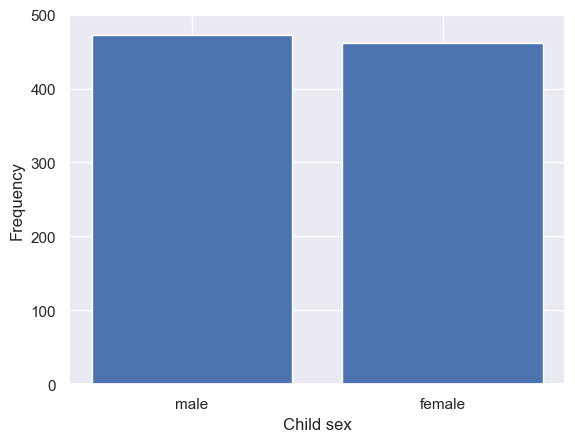

In [10]:
# set the theme for seaborn and matplotlib graphs
sns.set_theme()

# Count male and female babies
child_sex = df_demo['CFEMALEA1'].replace({0: 'male', 1: 'female'})
child_sex_counts = child_sex.value_counts()

# Plot male and female child sex counts
plt.bar(child_sex_counts.index, child_sex_counts.values)
plt.ylim(0,500)
# label y and x axis
plt.ylabel('Frequency')
plt.xlabel('Child sex');

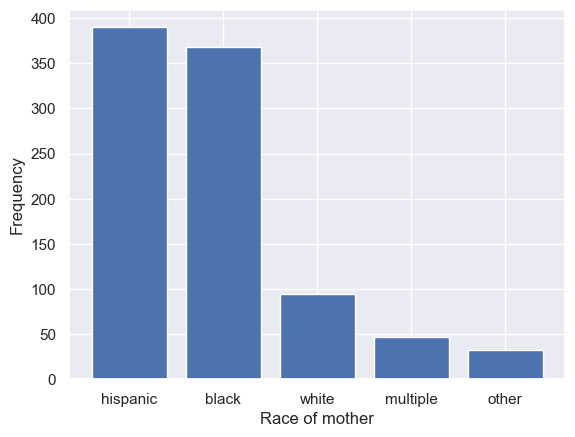

In [11]:
# dictionary of questionaire answer with associated race
int_race_conversion = {1: 'white', 2: 'black', 3: 'multiple', 4: 'other', 5: 'hispanic'}
# index dataframe by race and replace integer with race
mom_race = df_demo['MRACEA1'].replace(int_race_conversion)
# get the count per race
mom_race_counts = mom_race.value_counts()

# Plot mom races
plt.bar(mom_race_counts.index, mom_race_counts.values)
# label y and x axis 
plt.ylabel('Frequency')
plt.xlabel('Race of mother');

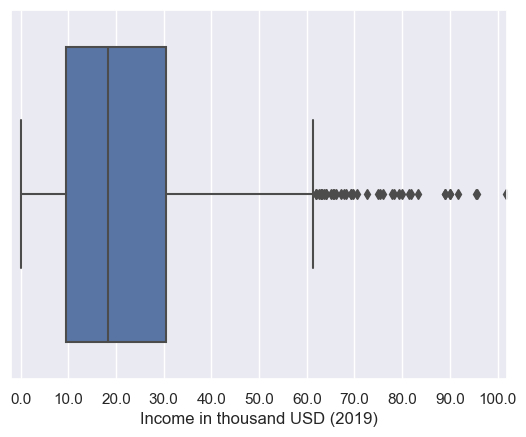

In [12]:
# make a boxplot of the household income 
sns.boxplot(df_demo['HHINCOMEA1'], orient='h')
plt.xlim(-2000,102000)
plt.xticks(np.linspace(0,100000, 11), labels=np.linspace(0,100,11))
# label axis 
plt.xlabel('Income in thousand USD (2019)')
plt.yticks([]);

### Child outcome variables examination:

In [13]:
# Other lang: TOT_CASQLANGA1, CASQLANGCUTOFFA1, CASQLANGA1
# Other BITSEA: CBITSEAPCUTOFFA1
 
# outcome features we are interested in using
outcome_feats = ['CBITSEAPA1', 'CSICKHEALTHA1', 'CPROMISA1',
          'TOT_CASQLANGA1']

# Higher BITSEA, POOR HEALTH, PROMIS = GREATER DISTURBANCES
# Higher ASQ = BETTER LANGUAGE DEVELOPMENT

# index dataframe by these outcome variables to just get these values
df_c_outcomes = df_bfy.loc[:,outcome_feats]

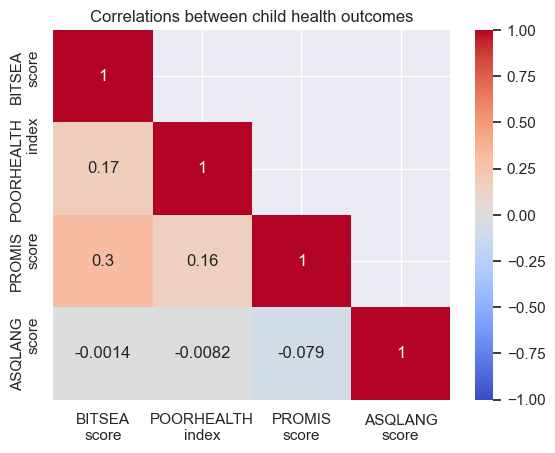

In [14]:
# determine correlation between outcome variables 
outcomes_corr = df_c_outcomes.corr()
outcome_corr_tri = np.tril(outcomes_corr)
outcome_corr_tri[outcome_corr_tri == 0] = np.nan
corr_labels = ['BITSEA\nscore', 'POORHEALTH\nindex', 'PROMIS\nscore', 'ASQLANG\nscore']

# make a heatmap of these correlations 
sns.heatmap(outcome_corr_tri, cmap="coolwarm", vmin=-1, vmax=1, annot=True,
           xticklabels=corr_labels, yticklabels=corr_labels)
plt.title('Correlations between child health outcomes');

Moderate positive correlations between child physical health, sleep disturbances, and social-emotional development. These three variables will be the focus of child outcome analyses. Negligent correlations with language development. 

In [15]:
# remove ASQLANG because it has negligible correlations
outcome_feats = outcome_feats[:3]

# **Outcome Feature Cleaning:**

### Are the outcome variables normally distributed?

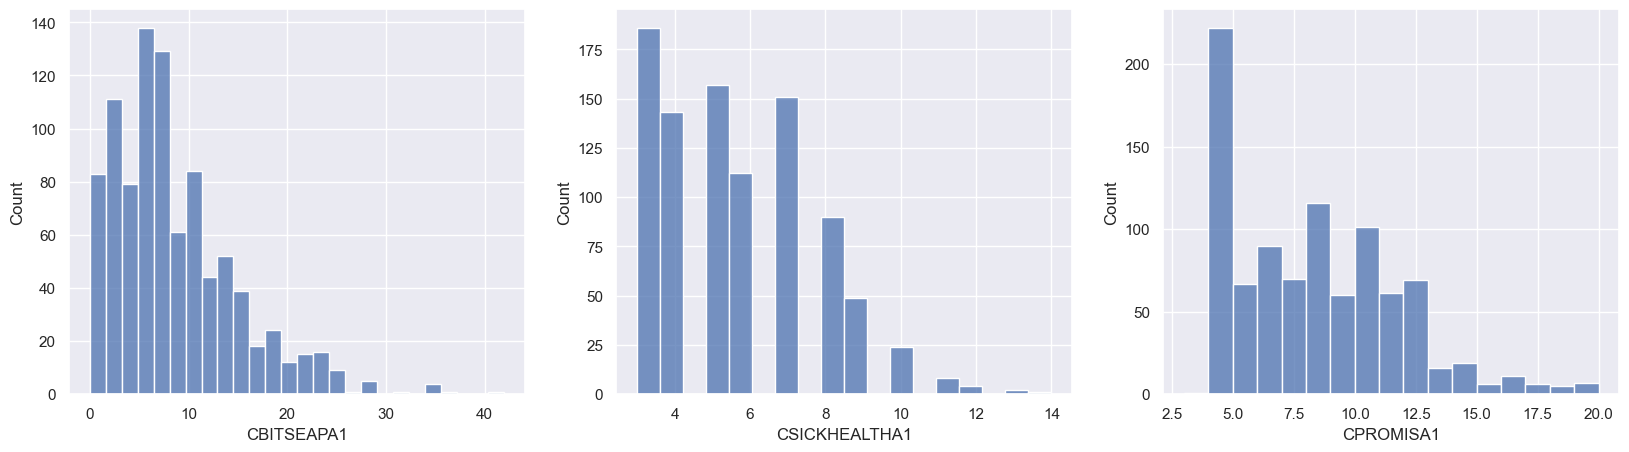

In [16]:
# Examine histogram distribution of outcome variables

def outcome_hist():
 
    # Create dist plots of each variable
    fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(20, 5))
    for i, ax in zip(range(len(outcome_feats)), axes.flat):
        # make a histograme of each of the outcome variables
        sns.histplot(df_bfy[outcome_feats[i]], ax=ax)
    plt.show()

outcome_hist()

Calculate skewness and kurtosis of outcome variables:

In [17]:
def calc_skew_kurt(scores):
    ''' Reports skewness and kurtosis of a feature, and whether they are significantly
    different from normal distribution
    
    Args:
        scores (1d np.array-like) : Assessment scores
        
    Returns:
        score_skew (float) : Skewness of score
        skew_z (float) : z-score of test to compute whether skewness differs from normal
        skew_p (float) : p-value of test to compute whether skewness differs from normal
        score_kurt (float) : Kurtosis of score
        kurt_z (float) : z-score of test to compute whether kurtosis differs from normal
        kurt_p (float) : p-value of test to compute whether kurtosis differs from normal
    '''
    
    # Measure skewness and difference from normal distribution
    score_skew = stats.skew(scores, nan_policy='omit')
    skew_z, skew_p = stats.skewtest(scores, nan_policy='omit')
    
    # Measure kurtosis and difference from normal distribution
    score_kurt = stats.kurtosis(scores, nan_policy='omit')
    kurt_z, kurt_p = stats.kurtosistest(scores, nan_policy='omit')
    
    
    return score_skew, skew_z, skew_p, score_kurt, kurt_z, kurt_p

Null hypothesis: The outcome variables are normally distributed (skewness and kurtosis not significantly different from 0). Reject if p <= 0.05

Alternative hypothesis: The outcome variables are not normally distributed (skewness and kurtosis are significantly different from 0).

In [18]:
# print the output of the calc_skew_kurt function after rounding the various measurements 
for outcome_feat in outcome_feats:
    outcome_scores = np.array(df_c_outcomes[outcome_feat])
    skew, skew_z, skew_p, kurt, kurt_z, kurt_p = calc_skew_kurt(outcome_scores)
    print(f'Outcome: {outcome_feat}')
    print(f'\tSkewness: {skew:.3f}')
    print(f'\t\tSkewness z-score: {skew_z:.3f}')
    print(f'\t\tSkewness p-value: {skew_p:.3f}')
    print(f'\tKurtosis: {kurt:.3f}')
    print(f'\t\tKurtosis z-score: {kurt_z:.3f}')
    print(f'\t\tKurtosis p-value: {kurt_p:.3f}')

Outcome: CBITSEAPA1
	Skewness: 1.272
		Skewness z-score: 12.594
		Skewness p-value: 0.000
	Kurtosis: 2.165
		Kurtosis z-score: 7.110
		Kurtosis p-value: 0.000
Outcome: CSICKHEALTHA1
	Skewness: 0.583
		Skewness z-score: 6.802
		Skewness p-value: 0.000
	Kurtosis: -0.139
		Kurtosis z-score: -0.817
		Kurtosis p-value: 0.414
Outcome: CPROMISA1
	Skewness: 0.761
		Skewness z-score: 8.536
		Skewness p-value: 0.000
	Kurtosis: 0.286
		Kurtosis z-score: 1.701
		Kurtosis p-value: 0.089


Conclusion: Child outcomes (social-emotional development, sleep disturbances, and physical health) are not normally distributed.

Takeaway: Normalize, don't standardize, data for future analyses. Do not assume normal distribution in future analyses.

### Feature scaling for child outcomes:

In [19]:
def normalize_scores(scores):
    ''' Imputes missing and normalizes feature scores
        ** Need to impute to normalize w/ sklearn **
    
    Args:
        scores (1d np.array-like) : Scores for one feature
    
    Returns:
        scores_norm (1d np.array) : Normalized scores
    '''
    
    # Confirm that scores are in 1d np.array format
    scores_arr = np.array(scores).reshape(-1,1)
    
    # impute by replacing missing values with median
    imp = SimpleImputer(missing_values=np.nan, strategy='median')
    imp.fit(scores_arr)
    scores_imp = imp.transform(scores_arr)

    # normalize the scores
    scores_norm = normalize(scores_imp, norm='max', axis=0)
    
    
    return scores_norm

In [20]:
# Normalize child outcome variables with median imputation for missing values
bitsea_norm = normalize_scores(df_c_outcomes['CBITSEAPA1'])
poor_health_norm = normalize_scores(df_c_outcomes['CSICKHEALTHA1'])
promis_norm = normalize_scores(df_c_outcomes['CPROMISA1'])

# Sum normalized outcome variable scores
# overall_c_outcome will be a score between 0 and 3, where
# 0 = less issues with social-emotional development, sleep, or physical health, and
# 3 = more issues with social-emotional development, sleep, or physical health
overall_c_outcome = (bitsea_norm + poor_health_norm + promis_norm).reshape(-1,)

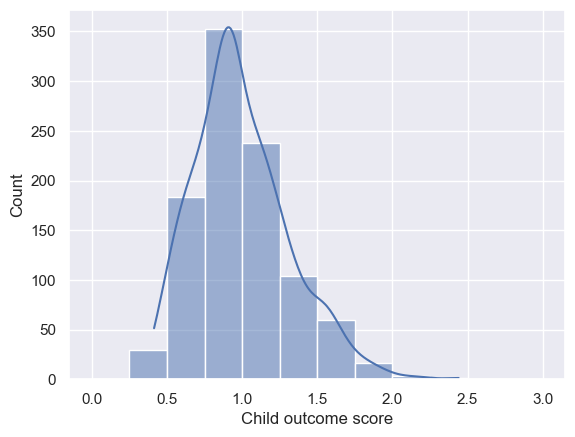

In [21]:
# histogram to show that the outcome data is now normalized 
sns.histplot(overall_c_outcome, bins=12, stat='count', binrange=(0,3), kde=True)
plt.xlabel('Child outcome score');

Individual child outcome features are normalized and summed together to one overall child outcome variable, whose value falls between 0 and 3. Values closer to 0 indicate healthy development, and values closer to 1 indicate poor development.

In [22]:
# add the outcome column to the final_df that currently contains all of the feature variables
final_df['CHILD_OUTCOME'] = overall_c_outcome

In [23]:
# Binarize child outcome: 0 = good health, 1 = poor health
# get the median of the outcome column
outcome_med = np.median(overall_c_outcome)
# split into bins based on the median 
final_df['CHILD_OUTCOME_BIN'] = np.where(overall_c_outcome <= outcome_med, 0, 1)

In [24]:
# now there are 37 total columns
print(final_df.shape)
# now the outcome column is binned 
final_df

(986, 37)


,MOMRACE_S_1A1,MOMORIGINA1,HHAGE1_ADULTSA1,MROMANTRELATIONA1,HHCOUNT_UNRELATEDADULTA1,HHAGE1CONTRPARTNERA1,HHAGE1CONTRBIODADA1,HHAGE1CONTROTHERADULTA1,HHAGE1CONTRCHILDA1,HHAGE1_ALLA1,...,MBECKCATA1,MPHQ8A1,MSLEEPA1,MPARENTINGSTRESSA1,MHAPPYA1,MPERCEIVEDSTRESSA1,LMCORTISOLA1,STEROIDS_B_2A1,CHILD_OUTCOME,CHILD_OUTCOME_BIN
0,2.0,5.0,1.0,0.0,0,0,0,0,0,2.0,...,1.0,0.0,15.0,14.0,1.0,13.0,NaN,5.0,0.771429,0
1,2.0,5.0,0.0,1.0,0,0,0,0,0,1.0,...,1.0,1.0,10.0,14.0,1.0,10.0,2.760010,5.0,0.876190,0
2,1.0,5.0,2.0,0.0,1,0,0,0,0,4.0,...,2.0,7.0,9.0,20.0,1.0,17.0,-0.223144,5.0,0.916667,0
3,2.0,5.0,3.0,0.0,2,0,0,2,0,5.0,...,1.0,0.0,15.0,16.0,2.0,6.0,NaN,5.0,0.914286,0
4,2.0,5.0,0.0,0.0,0,0,0,0,0,2.0,...,1.0,1.0,14.0,8.0,2.0,7.0,2.442347,5.0,0.916667,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,7.0,1.0,1.0,1.0,0,1,0,0,0,2.0,...,1.0,0.0,14.0,17.0,1.0,14.0,NaN,NaN,1.092857,1
996,2.0,5.0,1.0,1.0,0,1,1,0,0,4.0,...,1.0,0.0,11.0,13.0,2.0,13.0,NaN,NaN,1.145238,1
997,7.0,1.0,1.0,1.0,1,0,0,0,0,2.0,...,1.0,1.0,13.0,14.0,0.0,2.0,NaN,NaN,1.204762,1
998,7.0,1.0,1.0,1.0,0,1,1,0,0,2.0,...,1.0,0.0,12.0,10.0,2.0,6.0,NaN,NaN,0.714286,0


In [25]:
# Sklearn (decision tree and logistic regression) cannot handle missing values
# Fill missing values (nan) with mean of feature
fillna_dict = {column : final_df[column].mean() for column in final_df.columns}
final_df = final_df.fillna(value=fillna_dict)

# **Data Analysis - Classification:**

### Import relevant sklearn functions:

In [26]:
# import relevant sklearn functions 

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# we will be using logistic regression (class) and decision tree (class)
estimators = {
    'Logistic Regression' : LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier()}

In [27]:
'''calculate metrics'''

def metrics(method, estimator, model, predicted, y_test):
    """ method: base model, hyperparameter tuning
        estimator: different models (logistic regression, decision tree)
        model: trained model from given method and estimator
        predicted: using model to run on test set and find predicitons
        y_test: actual values corresponding to predictions"""
    
    # Find predicted and expected outcomes of model
    expected = y_test
    
    # Calculate classification report corresponding to model
    report = classification_report(y_true=expected, y_pred=predicted, output_dict=True)
    # do not want support metric, only accurracy, precision, recall, and f1-score, so delete support from dict
    del(report['0']['support'])
    del(report['1']['support'])
    return report

### Implement ML models using k-fold cross-validation:

In [28]:
def base_models(estimators, df, clf=True):
    '''initializes and runs the models and determines accuracy and other metrics'''
    
    if clf:
      # the features do not include the binned child outcome column nor the normal child outcome column 
      features = df.drop(columns = ["CHILD_OUTCOME_BIN", 'CHILD_OUTCOME'], axis = 1) 
      # target is the child outcome bin for logistic regression and decision tree
      target = df["CHILD_OUTCOME_BIN"]
    else: # target is continuous child outcome
      features = linreg_df.drop(columns = ['CHILD_OUTCOME'], axis = 1) 
      target = linreg_df["CHILD_OUTCOME"]

    # for each of the models: 
    for estimator_name, estimator_object in estimators.items():
        # split data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=3000)

        # select a classifier and create the model by fitting the training data
        model = estimator_object.fit(X=X_train, y=y_train)

        # predict outcome
        predicted = model.predict(X=X_test)
        print(estimator_name, ":")


        # report performance
        if clf:
          # prediction accuracy
          accuracy_test = model.score(X_test, y_test)
          accuracy_train = model.score(X_train, y_train)
          # round the accuracies 
          print("Prediction accuracy on the test data:", f"{accuracy_test:.2%}", "\n")
          print("Prediction accuracy on the train data:", f"{accuracy_train:.2%}", "\n")
          # run the metric function on this model, and output metrics 
          metric_dict = metrics('Base', estimator_name, model, predicted, y_test)
          print('Metrics for 0 (Good Health): ', metric_dict['0'])
          print('Metrics for 1 (Poor Health): ', metric_dict['1'], '\n')
        else:
          # Report model coefficients
          print("Coefficients: \n", model.coef_)
          # The mean squared error
          print("Mean squared error: %.2f" % mean_squared_error(y_test, predicted))
          # The coefficient of determination: 1 is perfect prediction
          print("Coefficient of determination (R^2): %.2f" % r2_score(y_test, predicted))


base_models(estimators, final_df)

Logistic Regression :
Prediction accuracy on the test data: 65.18% 

Prediction accuracy on the train data: 65.63% 

Metrics for 0 (Good Health):  {'precision': 0.6771653543307087, 'recall': 0.6564885496183206, 'f1-score': 0.6666666666666666}
Metrics for 1 (Poor Health):  {'precision': 0.625, 'recall': 0.646551724137931, 'f1-score': 0.635593220338983} 

Decision Tree :
Prediction accuracy on the test data: 59.11% 

Prediction accuracy on the train data: 100.00% 

Metrics for 0 (Good Health):  {'precision': 0.625, 'recall': 0.5725190839694656, 'f1-score': 0.5976095617529881}
Metrics for 1 (Poor Health):  {'precision': 0.5590551181102362, 'recall': 0.6120689655172413, 'f1-score': 0.5843621399176954} 



In [29]:
# import k fold and cross validation scores needed for k-fold cross validation 
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score

# produce the different classifiers, then can compare results and see which has the greatest accuracy 
def pre_featselect_k_fold_cv(estimators, clf=True):
    '''performs k-fold cross validation'''

    if clf:
      # features are everything but the binned or regular child outcome columns
      features = final_df.drop(columns=["CHILD_OUTCOME_BIN", 'CHILD_OUTCOME'], axis = 1) 
      # target for the logistic regression and decision tree models are the binned child outcomes
      target = final_df["CHILD_OUTCOME_BIN"]
    else: # target is continuous child outcome
      features = linreg_df.drop(columns = ['CHILD_OUTCOME'], axis = 1) 
      target = linreg_df["CHILD_OUTCOME"]

    # for each estimator 
    for estimator_name, estimator_object in estimators.items(): 
        # run k-fold cross validation 
        kfold = KFold(n_splits = 20, random_state = 3000, shuffle = True)
        
        if clf:
          # calculate the scores for the k-fold estimators 
          scores = cross_val_score(estimator = estimator_object, X=features, y=target, cv=kfold)
          # print the accurracies and standard devs for each of the models
          print(estimator_name + ": \n\t" + f"mean accuracy={scores.mean():.2%} " + f"standard deviation={scores.std():.2%}" + "\n")
        else:
          # if regression, accuracy comes from r2 calculation
          scores = cross_val_score(estimator = estimator_object, X=features, y=target,
                             scoring='r2', cv=kfold)
          print(estimator_name + ": \n\t" + f"mean r2={scores.mean():.2} " + f"standard deviation={scores.std():.2}" + "\n")

pre_featselect_k_fold_cv(estimators)

Logistic Regression: 
	mean accuracy=60.16% standard deviation=6.47%

Decision Tree: 
	mean accuracy=56.58% standard deviation=7.90%



### Feature selection for models:

In [30]:
# import models to do feature selection 
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import SelectFromModel

# features are everything but the binned or regular child outcome columns
features = final_df.drop(columns = ["CHILD_OUTCOME", 'CHILD_OUTCOME_BIN'], axis = 1) 

# target for the logistic regression and decision tree models are the binned child outcomes
target = final_df["CHILD_OUTCOME_BIN"]

# set train/test split 
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=3000)


def feature_selection(clf=True):
  '''selects the number of features wanted''' 

  # list to hold the features that will be selected  
  features_after = []

  if clf:
    # run rfe to iteratively select 20 best features
    select = RFE(DecisionTreeRegressor(random_state = 3000), n_features_to_select = 20)
  else:
    select = SelectFromModel(LinearRegression(), max_features = len(linreg_vars)-1)
  
  # fit the selector to the training data
  select.fit(X_train, y_train)
  # transform training and testing sets so only the selected features are retained
  X_train_selected = select.transform(X_train)
  X_test_selected = select.transform(X_test)
  # returns a Boolean mask of selected features
  bools = select.get_support()
  cols = features.loc[: ,bools].columns

  # print out the features that will be used & store them in list to return
  print("Selected features after selection:")
  for col in cols:
      features_after.append(col)
        
      print("\t"+col)
  return features_after 

features_after = feature_selection()

Selected features after selection:
	MOMRACE_S_1A1
	HHAGE1_ADULTSA1
	HHAGE1CONTROTHERADULTA1
	HHAGE1_ALLA1
	MRELATETYPEA1
	TOTEARNEDINCOMEA1
	TOTSPOUSEINCOMEA1
	TOTOTHHHMEMINCOMEA1
	TOTGOVTINCOMEA1
	TOTALLOTHERINCOMEA1
	COMBINEDINCOMEA1
	OPIOIDSPYA1
	MOMPREGA1
	MSATISFACTIONA1
	MPHQ8A1
	MSLEEPA1
	MPARENTINGSTRESSA1
	MHAPPYA1
	MPERCEIVEDSTRESSA1
	LMCORTISOLA1


In [31]:
#run kFold again to see how accuracy improved after feature selection

# produce the different classifiers, then can compare results and see which has the greatest accuracy 
def post_featselect_k_fold_cv(estimators, df, features, clf=True):
    '''performs k-fold cross validation'''

    # features are the prunned list from RFE above
    features = df[features]

    if clf:
      # target is the binned columns for logistic regression and decision tree
      target = df["CHILD_OUTCOME_BIN"]
    else: # target is continuous child outcome
      target = df["CHILD_OUTCOME"]
    
    # for each estimator
    for estimator_name, estimator_object in estimators.items(): 
        # run k-fold cross validation 
        kfold = KFold(n_splits = 20, random_state = 3000, shuffle = True)

        if clf:
          # calculate the scores for the k-fold estimators 
          scores = cross_val_score(estimator = estimator_object, X=features, y=target, cv=kfold)
          # print the accurracies and standard devs for each of the models
          print(estimator_name + ": \n\t" + f"mean accuracy={scores.mean():.2%} " + f"standard deviation={scores.std():.2%}" + "\n")
        else:
          # if regression, accuracy comes from r2 calculation
          scores = cross_val_score(estimator = estimator_object, X=features, y=target,
                             scoring='r2', cv=kfold)
          print(estimator_name + ": \n\t" + f"mean r2={scores.mean():.2} " + f"standard deviation={scores.std():.2}" + "\n")


post_featselect_k_fold_cv(estimators, final_df, features_after)

Logistic Regression: 
	mean accuracy=59.55% standard deviation=5.90%

Decision Tree: 
	mean accuracy=56.48% standard deviation=4.99%



### Hyperparameter tuning:

In [32]:
# import grid search from sklearn 
from sklearn.model_selection import GridSearchCV
from sklearn import tree
import graphviz 

def post_featselect_grid_search(estimators_dict, estimator, df, features, param_grid, clf=True):
    """ estimator: model to test with (logistic regression, svm, guassian nb, decision tree)
        df: dataframe to run models on
        features: list of feature colums from df
        param_grid: dictionary of different parameters and values to test and compare"""

    # use smaller list of features from feature selection
    features_after_selection = df[features] 

    if clf:
      # target for logistic regression and decision tree is the binned outcome
      target = df["CHILD_OUTCOME_BIN"]
    else: # target is continuous child outcome
      target = df['CHILD_OUTCOME']
    
    # Use grid search to find best parameters
    method = estimators_dict[estimator]
    grid_search = GridSearchCV(method, param_grid, cv=5)
    
    # Split into train and test sets, fit with grid search
    X_train, X_test, y_train, y_test = train_test_split(features_after_selection, target, random_state = 3000)
    model = grid_search.fit(X=X_train, y=y_train)
    
    # Print resulting best parameters and evaluation metrics
    print("Best parameters: ", grid_search.best_params_)
    
    print("Test set score: ", grid_search.score(X_test, y_test)) 
    print("Training set score: ", grid_search.score(X_train, y_train))
    
    # Evaluate performance metric
    predicted = grid_search.predict(X=X_test)

    if clf:
      metric_dict = metrics('Cross-Validated GridSearch', estimator, model, predicted, y_test)
      print('Metrics for 0 (Good Health): ', metric_dict['0'])
      print('Metrics for 1 (Poor Health): ', metric_dict['1'], '\n')
    else:
      # The mean squared error
      print("Mean squared error: %.2f" % mean_squared_error(y_test, predicted))
      # The coefficient of determination: 1 is perfect prediction
      print("Coefficient of determination (R^2): %.2f" % r2_score(y_test, predicted))

    best = grid_search.best_params_

    # create visualization of decision tree
    if estimator == "Decision Tree":
      t = DecisionTreeClassifier(criterion='entropy', max_depth=best['max_depth'], max_features=best['max_features'], max_leaf_nodes=best['max_leaf_nodes'], min_samples_split=best['min_samples_split'])
      model_t = t.fit(X=X_train, y=y_train)
      dot_data = tree.export_graphviz(model_t, out_file=None,
                      feature_names=features_after_selection.columns,
                      class_names=['Good Health', 'Poor Health'],
                      filled=True, rounded=True,
                      special_characters=True)
      graph = graphviz.Source(dot_data)  
      # return viz & score
      return graph, grid_search.score(X_test, y_test)   

    return grid_search.score(X_test, y_test)   

In [33]:
# Hyperparameters for Logistic Regression
param_grid = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
              'C': [0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50],
              'max_iter' : [100, 1000, 2500],
              'penalty': ['l1', 'l2']} 
log_reg_post_featselect_grid_search = post_featselect_grid_search(estimators, 'Logistic Regression', final_df, features_after, param_grid)
log_reg_post_featselect_grid_search

Best parameters:  {'C': 0.1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
Test set score:  0.6558704453441295
Training set score:  0.6468200270635994
Metrics for 0 (Good Health):  {'precision': 0.6825396825396826, 'recall': 0.6564885496183206, 'f1-score': 0.669260700389105}
Metrics for 1 (Poor Health):  {'precision': 0.628099173553719, 'recall': 0.6551724137931034, 'f1-score': 0.6413502109704642} 



0.6558704453441295

Best parameters:  {'criterion': 'gini', 'max_depth': 10, 'max_features': 10, 'max_leaf_nodes': 3, 'min_samples_split': 5}
Test set score:  0.6072874493927125
Training set score:  0.6495263870094723
Metrics for 0 (Good Health):  {'precision': 0.6103896103896104, 'recall': 0.7175572519083969, 'f1-score': 0.6596491228070176}
Metrics for 1 (Poor Health):  {'precision': 0.6021505376344086, 'recall': 0.4827586206896552, 'f1-score': 0.5358851674641149} 



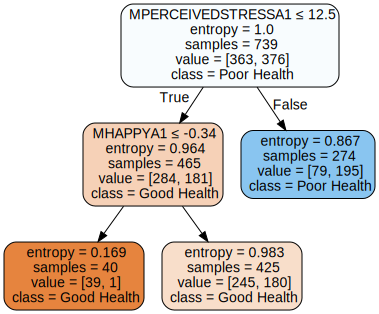

In [34]:
# Hyperparameters for Decision Tree
param_grid = {'criterion':['gini', 'entropy'], 
              'max_depth':[4, 5, 6, 7, 8, 9, 10, 100, 120], 
              'min_samples_split': [2, 5, 8, 10, 50, 100],  
              'max_leaf_nodes': [2, 3, 4, 5 , 10, 20], 
              'max_features': [10, 2]}
dtree_post_featselect_grid_search = post_featselect_grid_search(estimators, 'Decision Tree', final_df, features_after, param_grid)
dtree_post_featselect_grid_search[0]

In [35]:
# import grid search from sklearn 
from sklearn.model_selection import GridSearchCV

# perform grid search on more features now: 
# will use the 36 we pruned at the start, not the set from RFE 

def pre_featselect_grid_search(estimators_dict, estimator, df, param_grid, clf=True):
    """ estimator: model to test with (logistic regression, svm, guassian nb, decision tree)
        df: dataframe to run models on
        features: list of feature colums from df
        param_grid: dictionary of different parameters and values to test and compare"""

    if clf:
      # use all features 
      all_features = df.drop(columns = ['CHILD_OUTCOME_BIN', 'CHILD_OUTCOME'])
      # target for logistic regression and decision tree is the binned outcome
      target = df["CHILD_OUTCOME_BIN"]
    else:
      all_features = df.drop(columns = ['CHILD_OUTCOME'])
      # target is continuous child outcome
      target = df["CHILD_OUTCOME"]
    
    # Use grid search to find best parameters
    method = estimators_dict[estimator]
    grid_search = GridSearchCV(method, param_grid, cv=5)
    

    # Split into train and test sets, fit with grid search -- for ALL features
    X_train, X_test, y_train, y_test = train_test_split(all_features, target, random_state = 3000)
    model = grid_search.fit(X=X_train, y=y_train)
    
    # Print resulting best parameters and evaluation metrics -- for selected features
    print("Best parameters: ", grid_search.best_params_)
    
    print('For all chosen features:')
    print("Test set score: ", grid_search.score(X_test, y_test)) 
    print("Training set score: ", grid_search.score(X_train, y_train))
    
    # Evaluate performance metric
    predicted = grid_search.predict(X=X_test)

    if clf:
      metric_dict = metrics('Cross-Validated GridSearch', estimator, model, predicted, y_test)
      print('Metrics for 0 (Good Health): ', metric_dict['0'])
      print('Metrics for 1 (Poor Health): ', metric_dict['1'], '\n')
    else:
      # The mean squared error
      print("Mean squared error: %.2f" % mean_squared_error(y_test, predicted))
      # The coefficient of determination: 1 is perfect prediction
      print("Coefficient of determination (R^2): %.2f" % r2_score(y_test, predicted))

    
    best = grid_search.best_params_

    # create visualization of decision tree
    if estimator == "Decision Tree":
      t = DecisionTreeClassifier(criterion='entropy', max_depth=best['max_depth'], max_features=best['max_features'], max_leaf_nodes=best['max_leaf_nodes'], min_samples_split=best['min_samples_split'])
      model_t = t.fit(X=X_train, y=y_train)
      dot_data = tree.export_graphviz(model_t, out_file=None,
                      feature_names=all_features.columns,
                      class_names=['Good Health', 'Poor Health'],
                      filled=True, rounded=True,
                      special_characters=True)
      graph = graphviz.Source(dot_data)
      # return vis & score
      return graph, grid_search.score(X_test, y_test)  

    return grid_search.score(X_test, y_test) 

In [36]:
# Hyperparameters for Logistic Regression using all 36 features
param_grid = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
              'C': [0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50],
              'max_iter' : [100, 1000, 2500],
              'penalty': ['l1', 'l2']} 
log_reg_pre_featselect_grid_search = pre_featselect_grid_search(estimators, 'Logistic Regression', final_df, param_grid)

Best parameters:  {'C': 0.05, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}
For all chosen features:
Test set score:  0.6680161943319838
Training set score:  0.6508795669824087
Metrics for 0 (Good Health):  {'precision': 0.6991869918699187, 'recall': 0.6564885496183206, 'f1-score': 0.6771653543307087}
Metrics for 1 (Poor Health):  {'precision': 0.6370967741935484, 'recall': 0.6810344827586207, 'f1-score': 0.6583333333333333} 



Best parameters:  {'criterion': 'gini', 'max_depth': 6, 'max_features': 10, 'max_leaf_nodes': 4, 'min_samples_split': 50}
For all chosen features:
Test set score:  0.6882591093117408
Training set score:  0.6711772665764547
Metrics for 0 (Good Health):  {'precision': 0.7368421052631579, 'recall': 0.6412213740458015, 'f1-score': 0.6857142857142857}
Metrics for 1 (Poor Health):  {'precision': 0.6466165413533834, 'recall': 0.7413793103448276, 'f1-score': 0.6907630522088353} 



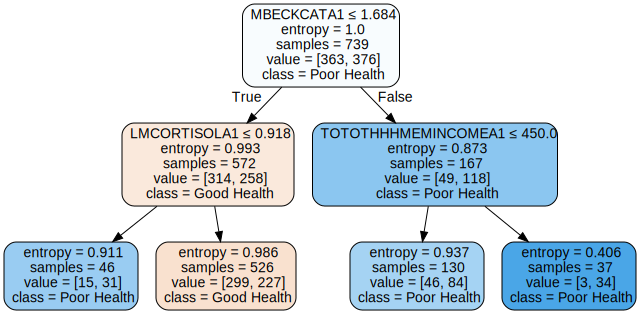

In [37]:
# Hyperparameters for Decision Tree using all 36 features
param_grid = {'criterion':['gini', 'entropy'], 
              'max_depth':[4, 5, 6, 7, 8, 9, 10, 100, 120], 
              'min_samples_split': [2, 5, 8, 10, 50, 100],  
              'max_leaf_nodes': [2, 3, 4, 5 , 10, 20], 
              'max_features': [10, 2]}
dtree_pre_featselect_grid_search = pre_featselect_grid_search(estimators, 'Decision Tree', final_df, param_grid)
dtree_pre_featselect_grid_search[0]

Logistic Regression and Decision Tree have lower test set accuracies when using the 36 features as opposed to the 20 from feature selection (which was done before this). 

# **Data Analysis - Multiple Regression:**

### Import relevant sklearn functions:

In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

linreg_estimator = {'Linear Regression' : LinearRegression()}

### Isolate continuous variables for regression analysis:

In [39]:
# Continuous measures of maternal anxiety and agency, relationship quality, and household chaos levels
cont_anxiety = 'MBECKA1'
hh_chaos = 'HHCHAOSA1'
m_agency = 'MHOPEA1'
cont_rel_quality = 'MRELATIONQUALITYA1'

# Compile list of continuous variables
linreg_vars = [depression, sleep, parenting_stress, perceived_stress, cont_anxiety, hh_chaos, m_agency,
              cont_rel_quality, log_transformed_cortisol,
               'TOTEARNEDINCOMEA1',
               'TOTGOVTINCOMEA1']

# Isolate DataFrame of continuous variables
linreg_df = df_bfy.loc[:,linreg_vars]

# Repeat imputation of missing values
fillna_dict = {column : linreg_df[column].mean() for column in linreg_df.columns}
linreg_df = linreg_df.fillna(value=fillna_dict)

# Add child outcome column
linreg_df['CHILD_OUTCOME'] = overall_c_outcome

# Peek into linreg DataFrame
linreg_df.head()

,MPHQ8A1,MSLEEPA1,MPARENTINGSTRESSA1,MPERCEIVEDSTRESSA1,MBECKA1,HHCHAOSA1,MHOPEA1,MRELATIONQUALITYA1,LMCORTISOLA1,TOTEARNEDINCOMEA1,TOTGOVTINCOMEA1,CHILD_OUTCOME
0,0.0,15.0,14.0,13.0,0.0,1.0,24.0,30.000000,1.791558,0.0,0.0,0.771429
1,1.0,10.0,14.0,10.0,1.0,1.0,21.0,26.000000,2.760010,0.0,0.0,0.876190
2,7.0,9.0,20.0,17.0,10.0,9.0,27.0,26.802102,-0.223144,13000.0,0.0,0.916667
3,0.0,15.0,16.0,6.0,3.0,1.0,31.0,29.000000,1.791558,8000.0,4500.0,0.914286
4,1.0,14.0,8.0,7.0,1.0,1.0,32.0,26.802102,2.442347,30000.0,0.0,0.916667


In [40]:
# Base model for linear regression with all continuous feats
base_models(linreg_estimator, linreg_df, clf=False)

Linear Regression :
Coefficients: 
 [ 8.89251915e-03 -1.74179541e-02  6.93676582e-03  4.59539239e-03
  4.28559893e-04  1.52083080e-02  1.59863507e-03 -3.17811847e-03
  5.34064142e-05  8.85864681e-07 -1.09511016e-06]
Mean squared error: 0.08
Coefficient of determination (R^2): 0.20


In [41]:
# Linear regression performance with cross-validation
pre_featselect_k_fold_cv(linreg_estimator, clf=False)

Linear Regression: 
	mean r2=0.15 standard deviation=0.13



In [42]:
# features are everything but the binned or regular child outcome columns
features = linreg_df.drop(columns = ["CHILD_OUTCOME"], axis = 1) 

# target for the logistic regression and decision tree models are the binned child outcomes
target = linreg_df["CHILD_OUTCOME"]

# set train/test split 
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=3000)

# Feature selection
linreg_features_after = feature_selection(clf=False)

Selected features after selection:
	MPHQ8A1
	MSLEEPA1
	MPARENTINGSTRESSA1
	HHCHAOSA1


In [43]:
# Linear regression performance with cross-validation and selected features
post_featselect_k_fold_cv(linreg_estimator, linreg_df, linreg_features_after, clf=False)

Linear Regression: 
	mean r2=0.16 standard deviation=0.12



In [44]:
# Hyperparameters for Linear Regression
param_grid = {'fit_intercept' : [True, False], 'positive' : [True, False], 'n_jobs' : [1,3,5,7,9]}

In [45]:
linreg_post_featselect_grid_search = post_featselect_grid_search(linreg_estimator, 'Linear Regression', linreg_df, linreg_features_after, param_grid, clf=False)

Best parameters:  {'fit_intercept': True, 'n_jobs': 1, 'positive': False}
Test set score:  0.1991281586967183
Training set score:  0.17689413073535432
Mean squared error: 0.08
Coefficient of determination (R^2): 0.20


In [46]:
linreg_pre_featselect_grid_search = pre_featselect_grid_search(linreg_estimator, 'Linear Regression', linreg_df, param_grid, clf=False)

Best parameters:  {'fit_intercept': True, 'n_jobs': 1, 'positive': False}
For all chosen features:
Test set score:  0.19971287600230758
Training set score:  0.18271416385351924
Mean squared error: 0.08
Coefficient of determination (R^2): 0.20


## Summarized Results

Text(0.5, 0, 'Model')

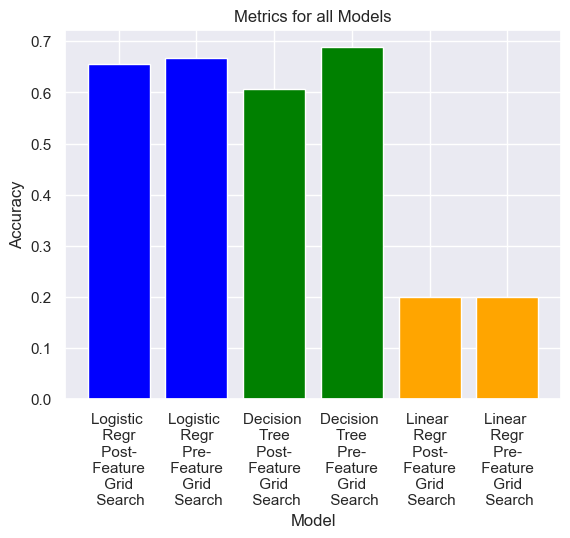

In [47]:
# names of the different models
names = ['Logistic \n Regr \n Post- \n Feature \n Grid \n Search', 
         'Logistic \n Regr \n Pre- \n Feature \n Grid \n Search', 
         'Decision \n Tree \n Post- \n Feature \n Grid \n Search',
         'Decision \n Tree \n Pre- \n Feature \n Grid \n Search', 
        'Linear \n Regr \n Post- \n Feature \n Grid \n Search', 
        'Linear \n Regr \n Pre- \n Feature \n Grid \n Search']

# accuracies of the models
accuracies = [log_reg_post_featselect_grid_search, log_reg_pre_featselect_grid_search, 
              dtree_post_featselect_grid_search[1], dtree_pre_featselect_grid_search[1], 
              linreg_post_featselect_grid_search, linreg_pre_featselect_grid_search]

# intialize a dictionary
accuracy_dict = {}
# add these names and accuracies into a dictionary using zip function
accuracy_dict = dict(zip(names, accuracies))
accuracy_dict

# using matplotlib, graph the accuracy dictionary for the models using a bar chart
# color code by logistic regr, decision tree, and linear regr
names, counts = zip(*accuracy_dict.items())
plt.bar(names, counts, color = ['blue', 'blue', 'green', 'green', 'orange', 'orange'])

# add a title and label the x and y axis 
plt.title('Metrics for all Models')
plt.ylabel('Accuracy')
plt.xlabel('Model')